In [3]:
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.nn import init
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../data2/data.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude"])

In [43]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        hidden_size = 64
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
#             nn.BatchNorm1d(hidden_size),
#             nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
#             nn.Dropout(0.5),
            nn.Linear(hidden_size, output_size)
        )
        
        for m in self.ffnn:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                            test_size=0.4, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNSimple(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 300000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it
grad_norms = []

def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [45]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=9e-3,
    weight_decay=1e-4
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999999, 
    patience=5, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    grad_norm = 0
    for tuple_ in train_loader:
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        grad_norm += get_gradient_norm(model)
        optimizer.step()

        running_loss += loss.item()
        
    grad_norms.append(grad_norm / len(train_loader))
    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in val_loader:
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
    scheduler.step(val_losses[-1])
    if epoch % 100 == 0:
        tl = f"Training Loss: {int(train_losses[-1])}"
        vl = f"Validation Loss: {int(val_losses[-1])}"
        l1 = f"L1: {int(l1_mean_loss)}"
        dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
        print(dl)

Epoch 1, Training Loss: 57706, Validation Loss: 79300, 544714.2953250317
Epoch 101, Training Loss: 16212, Validation Loss: 57488, 476321.5964711749
Epoch 201, Training Loss: 14242, Validation Loss: 55986, 643777.5222900927
Epoch 301, Training Loss: 12794, Validation Loss: 57778, 400984.1288185901
Epoch 401, Training Loss: 15117, Validation Loss: 56509, 402572.34697657
Epoch 501, Training Loss: 14301, Validation Loss: 57406, 604568.3877441789
Epoch 601, Training Loss: 13659, Validation Loss: 55992, 446902.3396072545
Epoch 701, Training Loss: 13177, Validation Loss: 56970, 497078.768496703
Epoch 801, Training Loss: 12967, Validation Loss: 55756, 442566.4118235769
Epoch 901, Training Loss: 14782, Validation Loss: 56865, 513505.21458876773
Epoch 1001, Training Loss: 15867, Validation Loss: 56409, 701768.3883504705
Epoch 1101, Training Loss: 14697, Validation Loss: 57228, 533387.6120425524
Epoch 1201, Training Loss: 13867, Validation Loss: 57215, 489579.2670355222
Epoch 1301, Training Loss:

Epoch 10801, Training Loss: 11140, Validation Loss: 58486, 440584.0532189442
Epoch 10901, Training Loss: 11930, Validation Loss: 58169, 487688.8872809497
Epoch 11001, Training Loss: 12761, Validation Loss: 59594, 547426.3470896835
Epoch 11101, Training Loss: 15153, Validation Loss: 58876, 625252.2991966812
Epoch 11201, Training Loss: 12712, Validation Loss: 59523, 596305.6738303278
Epoch 11301, Training Loss: 9127, Validation Loss: 58475, 347448.5598052243
Epoch 11401, Training Loss: 10578, Validation Loss: 59373, 434635.12319088104
Epoch 11501, Training Loss: 11197, Validation Loss: 58740, 481319.6078210422
Epoch 11601, Training Loss: 12098, Validation Loss: 59429, 445155.86370701075
Epoch 11701, Training Loss: 14873, Validation Loss: 58293, 610805.9292221079
Epoch 11801, Training Loss: 11369, Validation Loss: 57806, 420796.34126098716
Epoch 11901, Training Loss: 10614, Validation Loss: 58673, 419675.6768562656
Epoch 12001, Training Loss: 10962, Validation Loss: 57780, 431982.31751269

Epoch 21501, Training Loss: 12326, Validation Loss: 60747, 489845.1981148251
Epoch 21601, Training Loss: 10153, Validation Loss: 59698, 441840.6408679184
Epoch 21701, Training Loss: 11535, Validation Loss: 59020, 454822.20476757485
Epoch 21801, Training Loss: 10962, Validation Loss: 59142, 476324.2692109762
Epoch 21901, Training Loss: 10687, Validation Loss: 58927, 474093.5994671737
Epoch 22001, Training Loss: 10314, Validation Loss: 59753, 471797.1942511977
Epoch 22101, Training Loss: 9191, Validation Loss: 59092, 444658.20340678794
Epoch 22201, Training Loss: 10444, Validation Loss: 58882, 457487.22902190534
Epoch 22301, Training Loss: 11089, Validation Loss: 58646, 365373.7722407513
Epoch 22401, Training Loss: 10853, Validation Loss: 59347, 370101.1887741421
Epoch 22501, Training Loss: 9234, Validation Loss: 58912, 389877.0750379846
Epoch 22601, Training Loss: 8737, Validation Loss: 59295, 351387.2318175598
Epoch 22701, Training Loss: 9240, Validation Loss: 59321, 369841.2672113124


KeyboardInterrupt: 

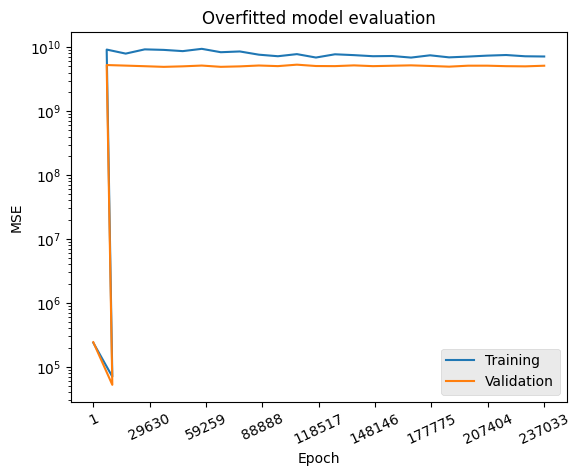

In [29]:
import matplotlib.pyplot as plt

train_losses_sampled = train_losses[::10000]  # Select every 1000th value
val_losses_sampled = val_losses[::10000]      # Select every 1000th value

# Generate corresponding epoch numbers, assuming epochs_suc is your list of epoch numbers
epochs_sampled = epochs_suc[::10000]

plt.title("Overfitted model evaluation")
plt.style.use("ggplot")

# Use sampled data for plotting
plt.plot(epochs_sampled, train_losses_sampled, label='Training')
plt.plot(epochs_sampled, val_losses_sampled, label='Validation')

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    rotation = 25
)
plt.legend()
plt.show()
# plt.savefig("../visualizations/overfit_model_evaluation_full_dataset.png", dpi=800)

# Saving. Good results

In [ ]:
# class TabularFFNNSimple(nn.Module):
#     def __init__(self, input_size, output_size, dropout_prob=0.4):
#         super(TabularFFNNSimple, self).__init__()
#         hidden_size = 48
#         self.ffnn = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
# #             nn.BatchNorm1d(hidden_size),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, output_size)
#         )
        
#         for m in self.ffnn:
#             if isinstance(m, nn.Linear):
#                 init.xavier_uniform_(m.weight)
#                 m.bias.data.fill_(0)

#     def forward(self, x):
#         x = x.float()
#         # print(x)
#         x = x.view(x.size(0), -1)
#         x = self.ffnn(x)
#         return x
    
# # Split the data into features and target
# X = data.drop('price', axis=1)
# y = data['price']

# # Standardize the features
# device = torch.device("cpu")
# # Convert to PyTorch tensors
# X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
# y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# # Split the data into training and combined validation and testing sets
# X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
#                                                             test_size=0.4, random_state=42)

# # Split the combined validation and testing sets
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# # Create DataLoader for training, validation, and testing
# train_data = TensorDataset(X_train, y_train)
# val_data = TensorDataset(X_val, y_val)
# test_data = TensorDataset(X_test, y_test)

# batch_size = 256
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # Check if the dimensions match the expected input size for the model
# input_size = X_train.shape[1]

# # Output
# # input_size, train_loader, test_loader

# model = TabularFFNNSimple(
#     input_size = input_size,
#     output_size = 1
# )
# model.to(device)

# num_epochs = 300000
# train_losses = []
# val_losses = []
# epochs_suc = [] # to have a reference to it
# grad_norms = []

# def get_gradient_norm(model):
#     total_norm = 0
#     for p in model.parameters():
#         if p.grad is not None:
#             param_norm = p.grad.data.norm(2)
#             total_norm += param_norm.item() ** 2
#     total_norm = total_norm ** 0.5
#     return total_norm

# optimizer = optim.Adam(
#     model.parameters(), 
#     lr=9e-3,
#     weight_decay=1e-4
# )
# criterion = torch.nn.MSELoss()
# criterion_abs = torch.nn.L1Loss()
# criterion = criterion_abs

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min', 
#     factor=0.999999, 
#     patience=10, 
#     verbose=True
# )

# for epoch in range(num_epochs):
#     # Training
#     model.train()  # Set the model to training mode
#     running_loss = 0.0
#     l1_losses = []
#     grad_norm = 0
#     for tuple_ in train_loader:
#         datas, prices = tuple_
#         optimizer.zero_grad()
#         outputs = model(datas)
#         prices_viewed = prices.view(-1, 1).float()
#         loss = criterion(outputs, prices_viewed)
#         loss.backward()
#         grad_norm += get_gradient_norm(model)
#         optimizer.step()

#         running_loss += loss.item()
        
#     grad_norms.append(grad_norm / len(train_loader))
#     train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

#     # Validation
#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation
#         for tuple_ in val_loader:
#             datas, prices = tuple_
#             outputs = model(datas)  # Forward pass
#             prices_viewed = prices.view(-1, 1).float()
#             loss = criterion(outputs, prices_viewed)  # Compute loss
#             val_loss += loss.item()  # Accumulate the loss
#             l1_losses.append(criterion_abs(outputs, prices_viewed))

#     val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
#     l1_mean_loss = sum(l1_losses) / len(l1_losses)
#     # Print epoch's summary
#     epochs_suc.append(epoch)
#     scheduler.step(val_losses[-1])
#     if epoch % 100 == 0:
#         tl = f"Training Loss: {int(train_losses[-1])}"
#         vl = f"Validation Loss: {int(val_losses[-1])}"
#         l1 = f"L1: {int(l1_mean_loss)}"
#         dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
#         print(dl)